In [6]:
import os
import copy
import time
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import time
import argparse
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision
from torchvision.datasets import MNIST, EMNIST

from utils.options import *
from utils.function import *
from utils.evaluation import *
from dataprocess.data_utils import *
from dataprocess.imbalance_cifar import *
from models.resnet import *
from models.vgg import *
from PIL import Image
from glob import glob
from torch.utils.data import SubsetRandomSampler, SequentialSampler
from torch.autograd import Variable
from matplotlib.pyplot import subplots
from torchvision.utils import save_image
import torchvision.models as models
from torch import Tensor

class Flatten(torch.nn.Module):
    r"""
    Flattens a contiguous range of dims into a tensor. For use with :class:`~nn.Sequential`.
    Args:
        start_dim: first dim to flatten (default = 1).
        end_dim: last dim to flatten (default = -1).

    Shape:
        - Input: :math:`(N, *dims)`
        - Output: :math:`(N, \prod *dims)` (for the default case).


    Examples::
        >>> m = nn.Sequential(
        >>>     nn.Conv2d(1, 32, 5, 1, 1),
        >>>     nn.Flatten()
        >>> )
    """
    __constants__ = ['start_dim', 'end_dim']
    start_dim: int
    end_dim: int

    def __init__(self, start_dim: int = 1, end_dim: int = -1) -> None:
        super(Flatten, self).__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, input: Tensor) -> Tensor:
        return input.flatten(self.start_dim, self.end_dim)

class CNN_Extractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encode = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            Flatten(),
            torch.nn.Linear(9216, 500),)
    def forward(self, x):
        return self.encode(x)

class CNN_Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.decode = torch.nn.Sequential(
            torch.nn.Linear(500, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 37),
            torch.nn.Softmax(dim=1),
        )
    def forward(self, x):
        return self.decode(x)
    

    
class AttackModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = torch.nn.Linear(500, 9216)

        self.layers = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                padding=1,
                stride=2,
                output_padding=1,
            ),
            torch.nn.ConvTranspose2d(
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                padding=1,
                stride=1,
                output_padding=0,
            ),
            torch.nn.ConvTranspose2d(
                in_channels=32,
                out_channels=8,
                kernel_size=3,
                padding=0,
                stride=1,
                output_padding=0,
            ),
            torch.nn.ConvTranspose2d(
                in_channels=8,
                out_channels=1,
                kernel_size=3,
                padding=0,
                stride=1,
                output_padding=0,
            ),
        )

    def forward(self, x):
        x = self.linear1(x)
        x = x.view(-1, 64, 12, 12)

        return self.layers(x)

def fix_mixup(x, label_num=3):
    x_ = x
    batch_size = x.size()[0]
    for i in range(label_num-1):
        lam_dim = []
        for j in range(batch_size):
            lam = np.random.beta(1., 1.)
            lam_dim.append(lam)
        lam_elem = torch.FloatTensor(lam_dim).cuda(gpu)
        lam_elem = lam_elem.view(lam_elem.size(0),1)
        index = torch.randperm(batch_size)
        one_vector = torch.ones(lam_elem.size()).cuda(gpu)
            
        mixed_x = lam_elem * x_ + (one_vector - lam_elem) * x[index, :]
        x_ = mixed_x
    
    return mixed_x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


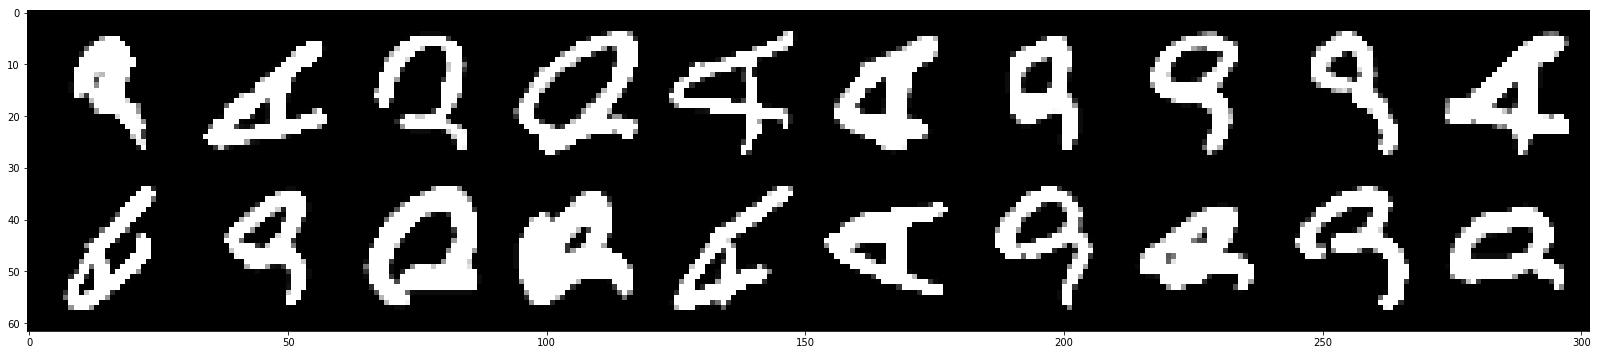

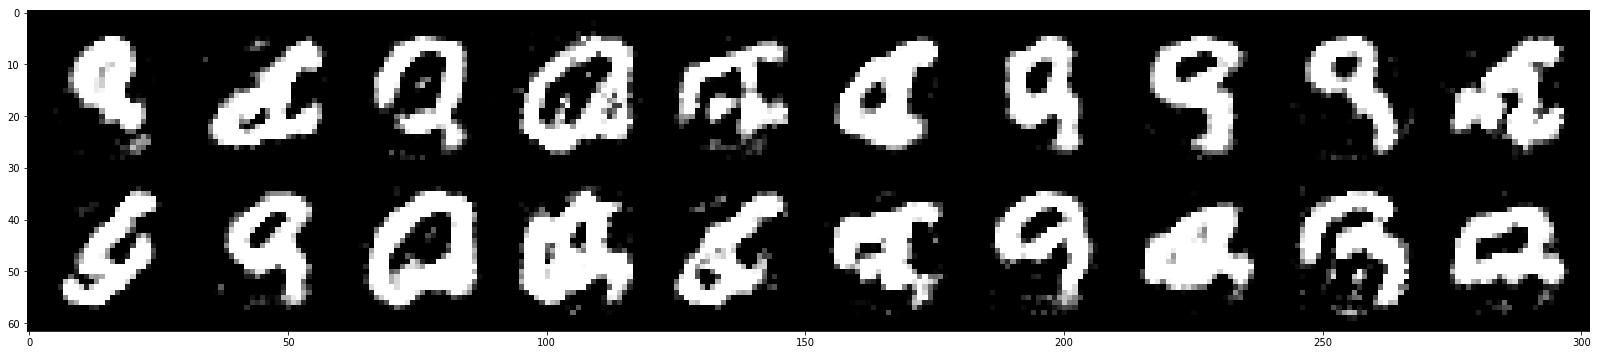

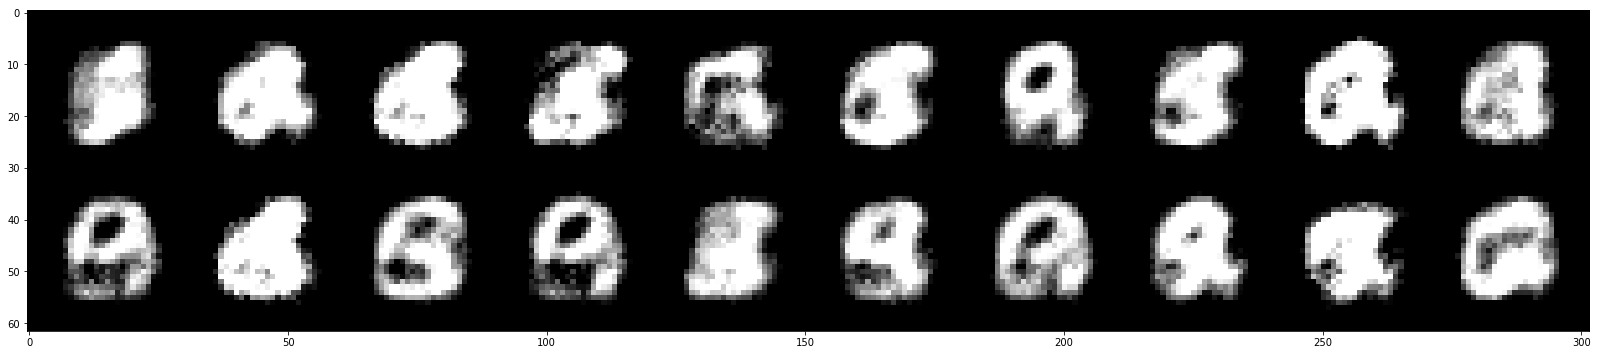

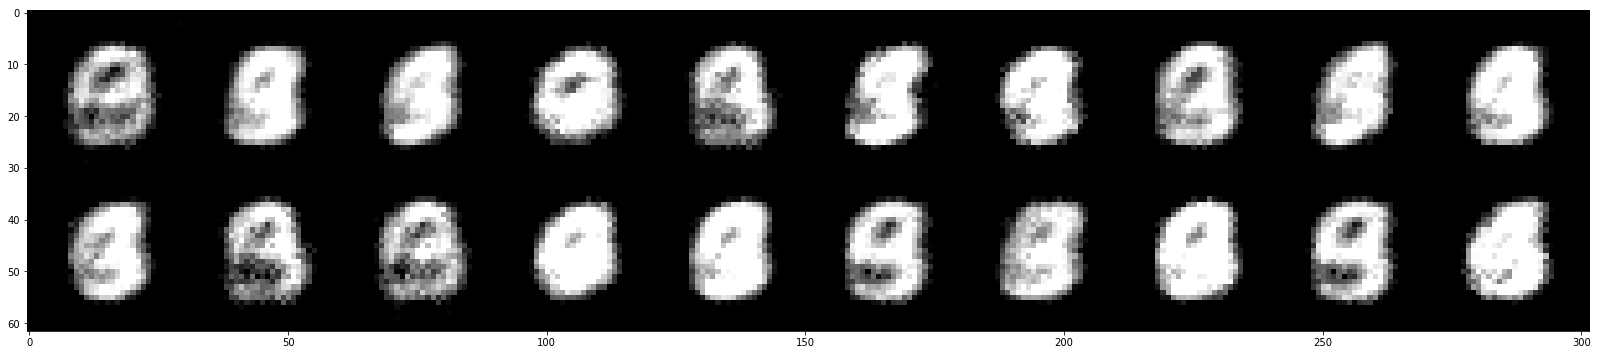

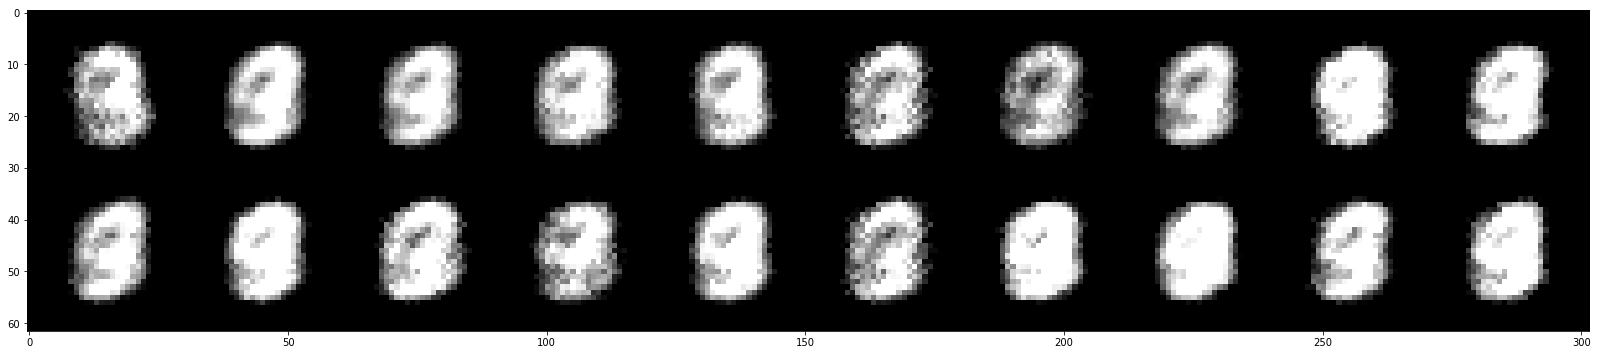

In [7]:
random_seed = 42
gpu = 0
test_bs = 20
num_samples = 5000
paths = ['sl-mnist-cnn' + str(num_samples)]
for i in range(3, 6):
    paths.append('mixsl-' + str(i) + '-mnist-cnn' + str(num_samples))

mix_num = [1, 3, 4, 5]

data_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
)
    
for i in range(len(paths)):
    ckpt = torch.load('../inversion/' + paths[i] + '.ckpt')
    extractor = CNN_Extractor()
    attacker = AttackModel()
    extractor.load_state_dict(ckpt['client'])
    attacker.load_state_dict(ckpt['attacker'])
    extractor.cuda(gpu)
    attacker.cuda(gpu)
    mnist_test = EMNIST('../data', 'letters', download=False, train=False, transform=data_transform)
    mnist_test.test_data = mnist_test.test_data[:20]
    mnist_test.test_labels = mnist_test.test_labels[:20]
    indices = list(range(len(mnist_test)))
    np.random.seed(random_seed)
    test_indices = indices[0:]
    test_sampler = SequentialSampler(test_indices)
    testloader = torch.utils.data.DataLoader(mnist_test, batch_size=test_bs, shuffle=False, num_workers=4, 
                                             sampler=test_sampler)
    for num, data in enumerate(testloader, 1):
        img, _ = data
        img = Variable(img).to(gpu)
        with torch.no_grad():
            intermediate = extractor(img)
            if i != 0:
                mixed = fix_mixup(intermediate, mix_num[i])
                reconstructed = attacker(mixed)
                reconstructed = reconstructed.squeeze(0)
            
                out0grid1 = torchvision.utils.make_grid(reconstructed, nrow=10)
                fig1, ax1 = subplots(figsize=(28, 28))
                ax1.imshow(out0grid1.detach().permute(1, 2, 0).cpu())
            else:#sl
                reconstructed = attacker(intermediate)
                reconstructed = reconstructed.squeeze(0)
            
                out0grid = torchvision.utils.make_grid(img, nrow=10)
                fig, ax = subplots(figsize=(28, 28))
                ax.imshow(out0grid.detach().permute(1, 2, 0).cpu())
                out0grid1 = torchvision.utils.make_grid(reconstructed, nrow=10)
                fig1, ax1 = subplots(figsize=(28, 28))
                ax1.imshow(out0grid1.detach().permute(1, 2, 0).cpu())
            